In [18]:
import h5py
import numpy as np
import random
from tqdm import tqdm
from collections import defaultdict
import pandas as pd

import torch
import torch.nn.functional as F

import h5py
import numpy as np
import random
from tqdm import tqdm


import h5py
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [7]:
input_file = '/mnt/f/hprc/hprc-v1.1-mc-chm13_segments.gfa'
output_file = '/mnt/f/hprc/segments_b.hdf5'

In [19]:
nucleotides = ['A', 'C', 'G', 'T']
nucleotide_to_index = {nuc: idx for idx, nuc in enumerate(nucleotides)}
vocab_size = len(nucleotides)

In [20]:
def encode_sequence_to_array(seq):
    seq = seq.upper()
    indices = [nucleotide_to_index.get(nuc, -1) for nuc in seq]
    indices = [idx for idx in indices if idx >= 0]
    # Convert indices to one-hot encoded numpy array
    one_hot_seq = np.eye(vocab_size, dtype=np.uint8)[indices]  # Shape: (seq_len, vocab_size)
    return one_hot_seq  # Returns a 2D array of shape (seq_len, vocab_size)

In [10]:
train_prob = 0.8
val_prob = 0.1
test_prob = 0.1

assert train_prob + val_prob + test_prob == 1.0, "The sum of split probabilities must be 1."

In [12]:
train_count = 0
val_count = 0
test_count = 0

In [13]:
# First pass to estimate the total number of sequences (optional, for progress tracking)
seq_lengths = defaultdict(int)
total_sequences = 0
with open(input_file, 'r') as f:
    for line in f:
        seq = line.strip().split("\t")[2]
        seq_lengths[len(seq)] += 1
        total_sequences += 1

print(f"Total sequences in input file: {total_sequences:,}")

Total sequences in input file: 92,879,580


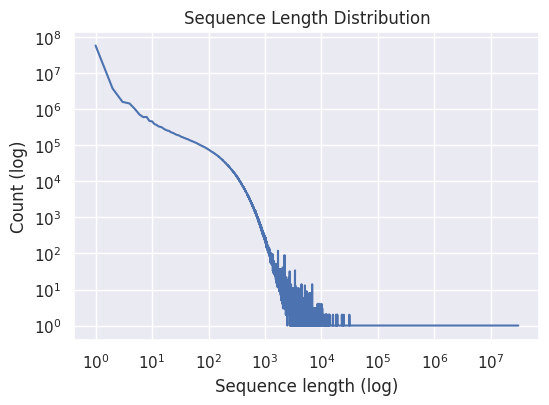

In [14]:
plt.figure(figsize=(6, 4))
ax = sns.lineplot(x=list(seq_lengths.keys()), y=list(seq_lengths.values()))
ax.set_yscale('log')
ax.set_xscale("log")

plt.xlabel("Sequence length (log)")
plt.ylabel("Count (log)")
plt.title('Sequence Length Distribution')

plt.show()

In [15]:
train_count = 0
val_count = 0
test_count = 0
max_segment_count = 100000

In [24]:
# Set buffer size for efficient writing
buffer_size = 1000  # Adjust based on your system's memory capacity
train_buffer = []
val_buffer = []
test_buffer = []

In [17]:
train_prob = 0.8
val_prob = 0.1
test_prob = 0.1
assert train_prob + val_prob + test_prob == 1.0, "Split probabilities must sum to 1."

In [22]:
# Define the fixed-size data type for one-hot vectors 
one_hot_dtype = np.dtype(('uint8', vocab_size)) 
# Each one-hot vector has length vocab_size 

# # Define the variable-length sequence data type using vlen 
vlen_dtype = h5py.vlen_dtype(one_hot_dtype)

In [25]:
with h5py.File(output_file, 'w') as hdf5_file:
    dt = h5py.special_dtype(vlen=np.uint8)
    train_dataset = hdf5_file.create_dataset('train_sequences', shape=(0,), maxshape=(None,), dtype=vlen_dtype)
    val_dataset = hdf5_file.create_dataset('val_sequences', shape=(0,), maxshape=(None,), dtype=vlen_dtype)
    test_dataset = hdf5_file.create_dataset('test_sequences', shape=(0,), maxshape=(None,), dtype=vlen_dtype)
    
    with open(input_file, 'r') as f:
        for line in tqdm(f, desc="Processing sequences", total=min(total_sequences, max_segment_count)):
            seq = line.strip().split("\t")[2]
            if not seq:
                continue
            try:
                one_hot_seq = encode_sequence_to_array(seq, line)
            except:
                # The sequence contains invalid neuclotides
                continue
            #flattened_seq = one_hot_seq.flatten()  # Flatten the 2D array into 1D
            rand_num = random.random()
            if rand_num < train_prob:
                train_buffer.append(one_hot_seq)
                train_count += 1
            elif rand_num < train_prob + val_prob:
                val_buffer.append(one_hot_seq)
                val_count += 1
            else:
                test_buffer.append(one_hot_seq)
                test_count += 1

            # Write buffers to datasets when they reach buffer_size
            if len(train_buffer) >= buffer_size:
                current_size = train_dataset.shape[0]
                train_dataset.resize((current_size + len(train_buffer),))
                train_dataset[current_size:] = train_buffer
                train_buffer = []
            if len(val_buffer) >= buffer_size:
                current_size = val_dataset.shape[0]
                val_dataset.resize((current_size + len(val_buffer),))
                val_dataset[current_size:] = val_buffer
                val_buffer = []
            if len(test_buffer) >= buffer_size:
                current_size = test_dataset.shape[0]
                test_dataset.resize((current_size + len(test_buffer),))
                test_dataset[current_size:] = test_buffer
                test_buffer = []

        # Write any remaining sequences in the buffers
        if train_buffer:
            current_size = train_dataset.shape[0]
            train_dataset.resize((current_size + len(train_buffer),))
            train_dataset[current_size:] = train_buffer
        if val_buffer:
            current_size = val_dataset.shape[0]
            val_dataset.resize((current_size + len(val_buffer),))
            val_dataset[current_size:] = val_buffer
        if test_buffer:
            current_size = test_dataset.shape[0]
            test_dataset.resize((current_size + len(test_buffer),))
            test_dataset[current_size:] = test_buffer

print(f"Finished processing. Train sequences: {train_count}, Validation sequences: {val_count}, Test sequences: {test_count}")


Processing sequences: 92879580it [03:19, 465343.02it/s]                         

Finished processing. Train sequences: 0, Validation sequences: 0, Test sequences: 0
